## Patches Experiment with Dex-Net

Goals:
* ~~Familiarize with data format~~
* ~~Run simple classifier~~
* ~~Design experiment workflow~~

Notes:
* Each data array has 46504 samples
* Moment arms is R6 wrench

In [1]:
#global imports
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import zero_one_loss, log_loss
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.qda import QDA
import matplotlib.pyplot as plt
%matplotlib inline

/home/jacky/anaconda2/lib/python2.7/site-packages/sklearn/qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


In [2]:
from util import PatchesDataLoader, PatchesSKLearner

In [19]:
data_path = '/home/jacky/ws/patches/data/'

In [20]:
pdl = PatchesDataLoader(0.25, data_path, [i for i in range(1)])

In [11]:
#QDA on fc
PatchesSKLearner.train(QDA, pdl.tr, pdl.labels['fc']['tr'], pdl.t, pdl.labels['fc']['t'], "QDA")

QDA train accuracy 0.870654488289, test accuracy 0.871466523387


/home/jacky/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)

In [12]:
#logistic regression on fc
PatchesSKLearner.train(linear_model.LogisticRegression, pdl.tr, pdl.labels['fc']['tr'], pdl.t, 
                       pdl.labels['fc']['t'], "Logistic Regression")

Logistic Regression train accuracy 0.906423497105, test accuracy 0.907256499806


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
PatchesSKLearner.train(RandomForestClassifier, pdl.tr, pdl.labels['fc']['tr'], pdl.t, pdl.labels['fc']['t'], "Random Forest Clf")

Random Forest Clf train accuracy 0.995572403638, test accuracy 0.93594221068


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [7]:
#analytical fc prediction using approx patch normals
X_w1_normals = pdl.get_partial_train_data(('w1_normal',))
X_w2_normals = pdl.get_partial_train_data(('w2_normal',))

In [8]:
def predict_single_approx_normals(w1, w2, mu = 0.5):
    alpha = np.arctan(mu)
    
    z1 = w1[2]
    z2 = w2[2]
    
    return np.arccos(-z1) < alpha and np.arccos(-z2) < alpha

def predict_approx_normals(W1, W2):
    n = W1.shape[0]
    results = []
    for i in range(n):
        results.append(predict_single_approx_normals(W1[i], W2[i]))
    return np.array(results)

In [9]:
approx_normal_tr_preds = predict_approx_normals(X_w1_normals['tr'], X_w2_normals['tr'])
approx_normal_t_preds = predict_approx_normals(X_w1_normals['t'], X_w2_normals['t'])

In [10]:
print "train loss", zero_one_loss(approx_normal_tr_preds, pdl.labels['fc']['tr'], normalize=True)
print "test loss", zero_one_loss(approx_normal_t_preds, pdl.labels['fc']['t'], normalize=True)

train loss 0.100561160528
test loss 0.0998179158831


min img [ 1.  0.] 0


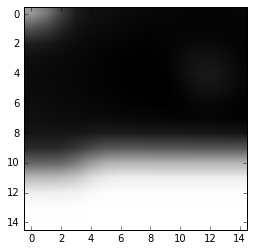

In [120]:
min_img_i = 250
print 'min img', preds_all[min_img_i], fc[min_img_i]
plt.imshow(w1_proj[min_img_i].reshape(15, 15), cmap='gray')

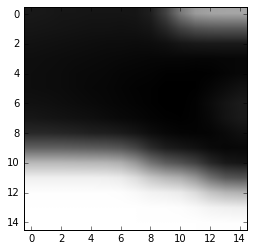

In [121]:
plt.imshow(w2_proj[min_img_i].reshape(15, 15), cmap='gray')

In [ ]:
max_img_i = 4
print 'max img', preds_all[max_img_i], fc[max_img_i]
plt.imshow(w1_proj[max_img_i].reshape(15, 15))

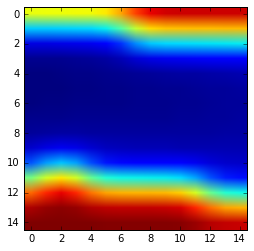

In [92]:
plt.imshow(w2_proj[max_img_i].reshape(15, 15))

In [6]:
#result just for normals
PatchesSKLearner.train(RandomForestClassifier, X_normals['tr'], pdl.labels['fc']['tr'], X_normals['t'], 
      pdl.labels['fc']['t'], "Random Forest Clf")

Random Forest Clf train accuracy 0.99346292792, test accuracy 0.960519525202


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
X_patch = pdl.get_partial_train_data(('patch_ori',))

In [9]:
PatchesSKLearner.train(QDA, X_patch['tr'], pdl.labels['fc']['tr'], X_patch['t'],
      pdl.labels['fc']['t'], "QDA")

QDA train accuracy 0.720912896382, test accuracy 0.723894718734


/home/jacky/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)

In [10]:
PatchesSKLearner.train(RandomForestClassifier, X_patch['tr'], pdl.labels['fc']['tr'], X_patch['t'],
      pdl.labels['fc']['t'], "Random Forest Clf")

Random Forest Clf train accuracy 0.986524456678, test accuracy 0.891794254258


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
pfc_reg = PatchesSKLearner.train(RandomForestRegressor, pdl.tr, pdl.labels['pfc_10']['tr'], pdl.t, pdl.labels['pfc_10']['t'],
      'Random Forest Regressor PFC', print_mse = True)

Random Forest Regressor PFC train accuracy 0.96422615806, test accuracy 0.797982278609
Random Forest Regressor PFC train mse 0.00363922183066, test mse 0.0205788539116


In [ ]:
#cross entropy loss for pfc
tr_pfc_preds = pfc_reg.predict(pdl.tr)
t_pfc_preds = pfc_reg.predict(pdl.t)
tr_pfc_preds_proba = np.c_[1 - tr_pfc_preds, tr_pfc_preds]
t_pfc_preds_proba = np.c_[1 - t_pfc_preds, t_pfc_preds]

In [17]:
ce_tr_pfc = log_loss(np.round(pdl.labels['pfc_10']['tr']), tr_pfc_preds_proba)
ce_t_pfc = log_loss(np.round(pdl.labels['pfc_10']['t']), t_pfc_preds_proba)
print "Random Forest Rergressor PFC train ce {0}, test ce {0}".format(ce_tr_pfc, ce_t_pfc)

Random Forest Rergressor PFC train ce 0.20100992797, test ce 0.20100992797


In [5]:
ferrari_reg = PatchesSKLearner.train(RandomForestRegressor, pdl.tr, pdl.labels['ferrari']['tr'], pdl.t, pdl.labels['ferrari']['t'],
      'Random Forest Regressor Ferrari Canny', print_mse= True)

Random Forest Regressor Ferrari Canny train accuracy 0.849162234482, test accuracy 0.792674878213
Random Forest Regressor Ferrari Canny train mse 4.36967714702e-08, test mse 6.0510454147e-08


In [18]:
#thresholding pfc to classify on fc
pfc_rd_tr = np.round(pdl.labels['pfc_10']['tr']).astype('int')
pfc_rd_t = np.round(pdl.labels['pfc_10']['t']).astype('int')

In [20]:
PatchesSKLearner.train(RandomForestClassifier, pdl.tr, pfc_rd_tr, pdl.t,
      pfc_rd_t, "Random Forest Clf on Rounded PFC")

Random Forest Clf on Rounded PFC train accuracy 0.995240552784, test accuracy 0.865043867194


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)